
<a id='lucas-asset'></a>

# Asset Pricing: The Lucas Asset Pricing Model

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).


<a id='index-0'></a>

## Overview

An asset is a claim on a stream of prospective payments.

What is the correct price to pay for such a claim?

The asset pricing model of Lucas [[Lucas, 1978](https://jax.quantecon.org/zreferences.html#id184)] attempts to answer this
question in an equilibrium setting with risk-averse agents.

Lucas’ model provides a beautiful illustration of model building in general and
equilibrium pricing in competitive models in particular.

In this lecture we work through the Lucas model and show where the fundamental
asset pricing equation comes from.

We’ll write code in both Numba and JAX.

Since the model is relatively small, the speed gain from using JAX is not as
large as it is in some other lectures.

Nonetheless, the gain is nontrivial.

Let’s start with some imports:

In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import numba
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from time import time

## The Lucas Model


<a id='index-1'></a>
Lucas studied a pure exchange economy with a representative consumer (or household), where

- *Pure exchange* means that all endowments are exogenous.  
- *Representative* consumer means that either  
  - there is a single consumer (sometimes also referred to as a household), or  
  - all consumers have identical endowments and preferences  


Either way, the assumption of a representative agent means that prices adjust to
eradicate desires to trade.

This makes it very easy to compute competitive equilibrium prices.

### Basic Setup

Let’s review the setup.

#### Assets


<a id='index-2'></a>
There is a single “productive unit” that costlessly generates a sequence of consumption goods $ \{y_t\}_{t=0}^{\infty} $.

这个单位持续不断地产生消费品，就像一棵树不断结出果实。

Another way to view $ \{y_t\}_{t=0}^{\infty} $ is as a *consumption endowment* for this economy.

We will assume that this endowment is Markovian, following the exogenous process

$$
y_{t+1} = G(y_t, \xi_{t+1})
$$

Here $ \{ \xi_t \} $ is an IID shock sequence with known distribution $ \phi $ and $ y_t \geq 0 $.

我们假设这个消费禀赋序列遵循一个 马尔可夫过程，即未来的消费水平 $y_{t+1}$ 只依赖于当前的状态 $y_t$ 和一个外生冲击 $\xi_{t+1}$，这个关系由函数 $G$ 决定。

- $G$ 是状态转移函数。

- ${\xi_t}$ 是一组独立同分布（IID）的随机变量，反映了不确定性。

- $\phi$ 是这些冲击的已知分布。

An asset is a claim on all or part of this endowment stream.

The consumption goods $ \{y_t\}_{t=0}^{\infty} $ are nonstorable, so holding assets is the only way to transfer wealth into the future.

For the purposes of intuition, it’s common to think of the productive unit as a “tree” that produces fruit.

Based on this idea, a “Lucas tree” is a claim on the consumption endowment.

#### Consumers


<a id='index-3'></a>
A representative consumer ranks consumption streams $ \{c_t\} $ according to the time separable utility functional


<a id='equation-lt-uf'></a>
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t u(c_t) \tag{8.1}
$$

Here

- $ \beta \in (0,1) $ is a fixed discount factor.  
- $ u $ is a strictly increasing, strictly concave, continuously differentiable period utility function.  
- $ \mathbb{E} $ is a mathematical expectation.  

这个模型中的代表性消费者：

- 决策目标是最大化整个生命周期中期望效用的贴现和；

- 每期的消费带来 $u(c_t)$ 的效用；

- 使用贴现因子 $\beta$ 来衡量对未来的耐心；

- 消费路径的不确定性用数学期望 $\mathbb{E}$ 来处理。

### Pricing a Lucas Tree


<a id='index-4'></a>
What is an appropriate price for a claim on the consumption endowment?

We’ll price an *ex-dividend* claim, meaning that

- the seller retains this period’s dividend  
- the buyer pays $ p_t $ today to purchase a claim on  
  - $ y_{t+1} $ （是分红）and  
  - the right to sell the claim tomorrow at price $ p_{t+1} $  


Since this is a competitive model, the first step is to pin down consumer
behavior, taking prices as given.

Next, we’ll impose equilibrium constraints and try to back out prices.

In the consumer problem, the consumer’s control variable is the share $ \pi_t $ of the claim held in each period.

Thus, the consumer problem is to maximize [(8.1)](#equation-lt-uf) subject to

$$
c_t + \pi_{t+1} p_t \leq \pi_t y_t + \pi_t p_t
$$

along with $ c_t \geq 0 $ and $ 0 \leq \pi_t \leq 1 $ at each $ t $.

The decision to hold share $ \pi_t $ is actually made at time $ t-1 $.

But this value is inherited as a state variable at time $ t $, which explains the choice of subscript.

- 实际上，$\pi_t$ 是 在 $t-1$ 时就决定的；

- 但是从第 $t$ 期的角度，它是既定的状态变量（已经决定好了，不能再改）；

- 所以我们仍用 $\pi_t$ 作为下标，而不是 $\pi_{t-1}$，这样看起来也方便表达预算约束。

#### The Dynamic Program


<a id='index-5'></a>
We can write the consumer problem as a dynamic programming problem.

Our first observation is that prices depend on current information, and current information is really just the endowment process up until the current period.

In fact, the endowment process is Markovian, so that the only relevant
information is the current state $ y \in \mathbb R_+ $ (dropping the time subscript).

- 虽然理论上价格可以依赖整个历史，但由于 $y_t$ 是马尔可夫过程，只取决于上期的 $y$ 和冲击 $\xi$；

- 因此，只需要用当前的 $y$ 作为状态变量就足够了；

- 所以我们可以猜测价格是 $y$ 的函数，写作 $p(y)$。

This leads us to guess an equilibrium where price is a function $ p $ of $ y $.

Remarks on the solution method

- Since this is a competitive (read: price taking) model, the consumer will take this function $ p $ as given.  
- In this way, we determine consumer behavior given $ p $ and then use equilibrium conditions to recover $ p $.  
- This is the standard way to solve competitive equilibrium models.  

1. 猜一个价格函数 $p(y)$；

2. 在这个价格函数下，求解消费者的最优行为（也就是 $\pi'$ 和 $c$ 的选择）；

3. 加上市场出清条件（比如所有资产都被持有 $\pi=1$），倒推出价格函数 $p(y)$；

4. 如果和猜的 $p(y)$ 一致，说明是均衡；否则更新再试。


Using the assumption that price is a given function $ p $ of $ y $, we write the value function and constraint as

$$
v(\pi, y) = \max_{c, \pi'}
    \left\{
        u(c) + \beta \int v(\pi', G(y, z)) \phi(dz)
    \right\}
$$

subject to


<a id='equation-preltbe'></a>
$$
c + \pi' p(y) \leq \pi y + \pi p(y) \tag{8.2}
$$

We can invoke the fact that utility is increasing to claim equality in [(8.2)](#equation-preltbe) and hence eliminate the constraint, obtaining

因为效用函数是严格递增的，消费者一定会用光所有预算，否则就是在浪费效用。


<a id='equation-ltbe'></a>
$$
v(\pi, y) = \max_{\pi'}
    \left\{
        u[\pi (y + p(y)) - \pi' p(y) ] + \beta \int v(\pi', G(y, z)) \phi(dz)
    \right\} \tag{8.3}
$$

The solution to this dynamic programming problem is an optimal policy expressing either $ \pi' $ or $ c $ as a function of the state $ (\pi, y) $.

- Each one determines the other, since $ c(\pi, y) = \pi (y + p(y))- \pi' (\pi, y) p(y) $  

#### Next Steps

What we need to do now is determine equilibrium prices.

It seems that to obtain these, we will have to

1. Solve this two-dimensional dynamic programming problem for the optimal policy.  
1. Impose equilibrium constraints.  
1. Solve out for the price function $ p(y) $ directly.  


However, as Lucas showed, there is a related but more straightforward way to do this.

#### Equilibrium Constraints


<a id='index-6'></a>
Since the consumption good is not storable, in equilibrium we must have $ c_t = y_t $ for all $ t $.

In addition, since there is one representative consumer (alternatively, since
all consumers are identical), there should be no trade in equilibrium.

In particular, the representative consumer owns the whole tree in every period, so $ \pi_t = 1 $ for all $ t $.

Prices must adjust to satisfy these two constraints.

#### The Equilibrium Price Function


<a id='index-7'></a>
Now observe that the first-order condition for [(8.3)](#equation-ltbe) can be written as

$$
u'(c)  p(y) = \beta \int v_1'(\pi', G(y, z)) \phi(dz)
$$

where $ v'_1 $ is the derivative of $ v $ with respect to its first argument.


这表示消费者做出最优选择 $\pi'$ 的时候，贝尔曼方程中对 $\pi'$ 的偏导数必须为零。 解释一下式子：
- 左边是放弃当前一点消费（边际效用 $u'(c)$）换取一单位资产 $\Rightarrow$ 成本是 $p(y)$；
- 右边是你得到未来资产 $\pi'$ 的边际价值 $\Rightarrow$ 是 $v$ 对 $\pi'$ 的偏导数（注意 $\pi'$ 是下期的 $\pi$）；
- 所以，这是**“边际成本 = 边际收益”** 的一阶条件（optimality condition）。

To obtain $ v'_1 $ we can simply differentiate the right-hand side of
[(8.3)](#equation-ltbe) with respect to $ \pi $, yielding

$$
v'_1(\pi, y) = u'(c) (y + p(y))
$$

Next, we impose the equilibrium constraints while combining the last two
equations to get


<a id='equation-lteeq'></a>
$$
p(y)  = \beta \int \frac{u'[G(y, z)]}{u'(y)} [G(y, z) + p(G(y, z))]  \phi(dz) \tag{8.4}
$$

- 在均衡中，$c_t = y_t$，$\pi_t = 1$；

- 所以 $c = y$，$\pi = 1$，$\pi' = 1$；

- $u'(c) = u'(y)$，$G(y, z)$ 是下一期的禀赋 $y_{t+1}$；

In sequential rather than functional notation, we can also write this as


<a id='equation-lteeqs'></a>
$$
p_t = \mathbb{E}_t \left[ \beta \frac{u'(c_{t+1})}{u'(c_t)} ( y_{t+1} + p_{t+1} ) \right] \tag{8.5}
$$

- $y \to y_t$

- $G(y, z) \to y_{t+1}$

- $p(G(y, z)) \to p_{t+1}$

- $\mathbb{E}t[\cdot]$ 是对 $z$ 或 $\xi{t+1}$ 的期望

This is the famous consumption-based asset pricing equation.

Before discussing it further we want to solve out for prices.

### Solving the Model


<a id='index-8'></a>
Equation [(8.4)](#equation-lteeq) is a *functional equation* in the unknown function $ p $.

The solution is an equilibrium price function $ p^* $.

Let’s look at how to obtain it.

#### Setting up the Problem

Instead of solving for it directly we’ll follow Lucas’ indirect approach, first setting


<a id='equation-ltffp'></a>
$$
f(y) := u'(y) p(y) \tag{8.6}
$$


也就是说，把价格函数 $p(y)$ 乘上边际效用 $u'(y)$，定义一个新的函数 $f(y)$。 这是合理的，因为 $u'(y)$ 在模型中经常出现，特别是作为 **贴现权重**（SDF），现在我们把它整合进价格函数里了。

so that [(8.4)](#equation-lteeq) becomes


<a id='equation-lteeq2'></a>
$$
f(y) = h(y) + \beta \int f[G(y, z)] \phi(dz) \tag{8.7}
$$

Here $ h(y) := \beta \int u'[G(y, z)] G(y, z)  \phi(dz) $ is a function that
depends only on the primitives.




Equation [(8.7)](#equation-lteeq2) is a functional equation in $ f $.

The plan is to solve out for $ f $ and convert back to $ p $ via [(8.6)](#equation-ltffp).

To solve [(8.7)](#equation-lteeq2) we’ll use a standard method: convert it to a fixed point problem.

固定点问题就是：找一个输入，使得函数作用后仍然得到它自己。

First, we introduce the operator $ T $ mapping $ f $ into $ Tf $ as defined by


<a id='equation-lteeqt'></a>
$$
(Tf)(y) = h(y) + \beta \int f[G(y, z)] \phi(dz) \tag{8.8}
$$

In what follows, we refer to $ T $ as the Lucas operator.

把右边视作一个操作 $T(f)$，变成 $f = T(f)$

The reason we do this is that a solution to [(8.7)](#equation-lteeq2) now corresponds to a
function $ f^* $ satisfying $ (Tf^*)(y) = f^*(y) $ for all $ y $.

In other words, a solution is a *fixed point* of $ T $.

This means that we can use fixed point theory to obtain and compute the solution.

#### A Little Fixed Point Theory


<a id='index-9'></a>
Let $ cb\mathbb{R}_+ $ be the set of continuous bounded functions $ f \colon \mathbb{R}_+ \to \mathbb{R}_+ $.

We now show that

1. $ T $ has exactly one fixed point $ f^* $ in $ cb\mathbb{R}_+ $.  
1. For any $ f \in cb\mathbb{R}_+ $, the sequence $ T^k f $ converges
  uniformly to $ f^* $.  


>**Note**
>
>If you find the mathematics heavy going you can take 1–2 as given and skip to the [next section](#lt-comp-eg)

Recall the [Banach contraction mapping theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem).

如果一个函数 $T$ 把一个空间里的点映射到自身，并且它是一个“收缩映射”，
那么就存在唯一的固定点 $x^$，使得 $T(x^) = x^$，
而且从任意初始点 $x_0$ 出发不断迭代 $x_{n+1} = T(x_n)$，最终都收敛到 $x^$。




It tells us that the previous statements will be true if we can find an
$ \alpha < 1 $ such that


<a id='equation-ltbc'></a>
$$
\| Tf - Tg \| \leq \alpha \| f - g \|,
\qquad \forall \, f, g \in cb\mathbb{R}_+ \tag{8.9}
$$

Here $ \|h\| := \sup_{x \in \mathbb{R}_+} |h(x)| $.

To see that [(8.9)](#equation-ltbc) is valid, pick any $ f,g \in cb\mathbb{R}_+ $ and any $ y \in \mathbb{R}_+ $.

Observe that, since integrals get larger when absolute values are moved to the
inside,

$$
\begin{aligned}
    |Tf(y) - Tg(y)|
    & = \left| \beta \int f[G(y, z)] \phi(dz)
        -\beta \int g[G(y, z)] \phi(dz) \right|
    \\
    & \leq \beta \int \left| f[G(y, z)] -  g[G(y, z)] \right| \phi(dz)
    \\
    & \leq \beta \int \| f -  g \| \phi(dz)
    \\
    & = \beta  \| f -  g \|
\end{aligned}
$$

Since the right-hand side is an upper bound, taking the sup over all $ y $
on the left-hand side gives [(8.9)](#equation-ltbc) with $ \alpha := \beta $.


<a id='lt-comp-eg'></a>

- $\beta < 1$，所以 $T$ 是收缩映射；

- 函数空间 $cb\mathbb{R}_+$ 是完备的；

- 所以 Banach 定理告诉我们：存在唯一的函数 $f^$ 满足 $Tf^ = f^*$；

- 并且我们可以通过 $f_{n+1} = Tf_n$ 不断迭代逼近它；

- 最终通过 $p(y) = \frac{f^*(y)}{u'(y)}$ 得到价格函数。

## Computation


<a id='index-10'></a>
The preceding discussion tells that we can compute $ f^* $ by picking any arbitrary $ f \in cb\mathbb{R}_+ $ and then iterating with $ T $.

The equilibrium price function $ p^* $ can then be recovered by $ p^*(y) = f^*(y) / u'(y) $.

Let’s try this when $ \ln y_{t+1} = \alpha \ln y_t + \sigma \epsilon_{t+1} $ where $ \{\epsilon_t\} $ is IID and standard normal.

这是一种经典的**对数正态 AR(1) 过程**，也叫 **几何布朗运动离散版本**，表示消费禀赋 $y_t$ 的演化过程。
- $\epsilon_t \sim \mathcal{N}(0, 1)$ 是独立标准正态分布；
- $\alpha$ 控制“记忆性”或“均值回归”；
- $\sigma$ 控制波动性；
- 换句话说，这是：
$$
y_{t+1} = \exp(\alpha \ln y_t + \sigma \epsilon_{t+1}) = y_t^\alpha \cdot e^{\sigma \epsilon_{t+1}}
$$

Utility will take the isoelastic form $ u(c) = c^{1-\gamma}/(1-\gamma) $, where $ \gamma > 0 $ is the coefficient of relative risk aversion.


这是CRRA（恒定相对风险厌恶）效用函数，其中：

- $\gamma$ 是风险厌恶系数；

- 特例：当 $\gamma \to 1$ 时，$u(c) \to \log c$。

We’ll use Monte Carlo to compute the integral

$$
\int f[G(y, z)] \phi(dz)
$$

Monte Carlo is not always the fastest method for computing low-dimensional
integrals, but it is extremely flexible (for example, it’s straightforward to
change the underlying state process).

Monte Carlo 方法就是用“随机抽样 + 平均”来估计一个期望或积分。

- **灵活**：不管 $G(y, z)$ 的形式多复杂、分布 $\phi$ 多奇怪，都可以用模拟来处理；
- **方法**：从 $\phi$（这里是标准正态）中抽 $N$ 个样本 $\{z_i\}$，近似计算积分为：
$$
\int f[G(y, z)] \phi(dz) \approx \frac{1}{N} \sum_{i=1}^N f(G(y, z_i))
$$

虽然在维度较低时（比如一维积分），Monte Carlo 不是最快的（比如高斯求积更快），但它在更复杂的情形（多维状态变量、非正态分布）下非常方便，也更容易推广。

### Numba Code

Let’s start with code using NumPy / Numba (and then compare it to code using
JAX).

We create a function that returns tuples containing parameters and arrays needed
for computation.

In [2]:
def create_lucas_tree_model(γ=2,            # CRRA utility parameter
                            β=0.95,         # Discount factor
                            α=0.90,         # Correlation coefficient
                            σ=0.1,          # Volatility coefficient
                            grid_size=500, #状态空间中 $y$ 的离散点数量；
                            draw_size=1_000, #模拟蒙特卡洛样本数量
                            seed=11):
        # Set the grid interval to contain most of the mass of the
        # stationary distribution of the consumption endowment
        ssd = σ / np.sqrt(1 - α**2)
        grid_min, grid_max = np.exp(-4 * ssd), np.exp(4 * ssd)
        grid = np.linspace(grid_min, grid_max, grid_size)
        # Set up distribution for shocks
        np.random.seed(seed)
        ϕ = lognorm(σ)
        draws = ϕ.rvs(500)
        # And the vector h
        h = np.empty(grid_size)
        for i, y in enumerate(grid):
            h[i] = β * np.mean((y**α * draws)**(1 - γ))
        # Pack and return
        params = γ, β, α, σ
        arrays = grid, draws, h
        return params, arrays

```python
ssd = σ / np.sqrt(1 - α**2)
grid_min, grid_max = np.exp(-4 * ssd), np.exp(4 * ssd)
grid = np.linspace(grid_min, grid_max, grid_size)
```
这是在为 $y_t$ 构造状态网格（grid）：

- 原始的 log-$y$ 服从 AR(1)：$\ln y_{t+1} = \alpha \ln y_t + \sigma \epsilon_{t+1}$；

- 这个过程的平稳标准差是 $\text{ssd} = \sigma / \sqrt{1 - \alpha^2}$；

- 所以 $\ln y$ 的 95% 区间大概是 $[-4 \cdot \text{ssd}, +4 \cdot \text{ssd}]$；

- 变回 $y$ 本身，用指数函数；

- 然后用 np.linspace 把 $y$ 的取值区间等分为 grid_size 个点。

✅ 得到的是一组 $y$ 值组成的网格 grid。

在这个 Lucas Tree 模型中，grid 是一个对 $y$ 的状态空间的离散近似。也就是说：

- $y_t$ 是一个连续变量（消费禀赋）；

- 但计算机不能处理无穷多的连续值，所以我们要在一个区间内选取一组 代表性点，来近似整个连续空间；

- 这些代表性点就构成了我们说的 grid（网格）。

```python
np.random.seed(seed)
ϕ = lognorm(σ)
draws = ϕ.rvs(500)

```
设置随机种子，确保结果可复现；

- lognorm(σ) 表示 $e^{\sigma \epsilon}$ 的分布（$\epsilon \sim N(0, 1)$）；

- 所以 $y_{t+1} = y_t^\alpha \cdot e^{\sigma \epsilon}$ 中的 $e^{\sigma \epsilon}$ 就可以直接用对数正态分布模拟；

- draws 就是 500 个随机样本 ${e^{\sigma \epsilon_i}}$，用于 Monte Carlo 积分。
```python
h = np.empty(grid_size)
for i, y in enumerate(grid):
    h[i] = β * np.mean((y**α * draws)**(1 - γ))
```
这里计算的是 $h(y)$，也就是 Lucas operator 中不依赖于 $f$ 的那一项；

$$ h(y) := \beta \int u'[G(y, z)] G(y, z)  \phi(dz) $$

$z := e^{\sigma \epsilon}$，因为 $G(y, z) = y^\alpha \cdot z$（其实就是yt+1,由yt的dynamic来的）

$u'(c) \cdot c = c^{1 - \gamma}$ 以及y=c，所以 $h(y) = \beta \cdot \mathbb{E}[(y^\alpha \cdot Z)^{1 - \gamma}]$，其中 $Z = e^{\sigma \epsilon}$；

使用蒙特卡洛方法估计期望，方法是对 $(y^\alpha \cdot \text{draws})^{1 - \gamma}$ 取平均再乘以 $\beta$。



Here’s a Numba-jitted version of the Lucas operator

In [3]:
@numba.jit
def T(params, arrays, f):
    """
    The Lucas pricing operator.
    """
    # Unpack
    γ, β, α, σ = params
    grid, draws, h = arrays
    # Turn f into a function
    Af = lambda x: np.interp(x, grid, f)
    # Compute Tf and return
    Tf = np.empty_like(f) #Tf 是我们要返回的 $T(f)$，形状和输入 $f$ 一样。
    # Apply the T operator to f using Monte Carlo integration
    for i in range(len(grid)):
        y = grid[i]
        Tf[i] = h[i] + β * np.mean(Af(y**α * draws)) # 括号里面的是模拟出的 $y_{t+1}$ 值
    return Tf

```python
Af = lambda x: np.interp(x, grid, f)

```

这里定义了一个插值函数 Af(x)，它在状态网格 grid 上对 $f$ 做线性插值；

因为 $y^\alpha \cdot z$ 可能不正好落在网格点上，我们要通过插值在 $f$ 上估值。
```python
Af(y**α * draws)
```
对模拟出来的 $y_{t+1}$ 值，用插值函数在 $f$ 上求值；

相当于 $\text{Evaluate } f(G(y, z))$。.

最终计算：

$$
(Tf)(y) = h(y) + \beta \cdot \mathbb{E}[f(G(y, z))] \approx h[i] + \beta \cdot \frac{1}{N} \sum_{i=1}^N f(G(y, z_i))
$$

也就是我们之前的 Lucas operator 迭代式：

$$
(Tf)(y) = h(y) + \beta \int f(G(y, z)) \, \phi(dz)
$$

To solve the model, we write a function that iterates using the Lucas operator
to find the fixed point.

In [4]:
def solve_model(params, arrays, tol=1e-6, max_iter=500):
    """
    Compute the equilibrium price function.

    """
    # Unpack
    γ, β, α, σ = params
    grid, draws, h = arrays
    # Set up and loop
    i = 0
    f = np.ones_like(grid)  # Initial guess of f，初始猜测函数 $f_0(y)$ 为全 1 向量；
    error = tol + 1 # 初始化误差 error 大于 tol，确保循环开始。
    while error > tol and i < max_iter:
        Tf = T(params, arrays, f)
        error = np.max(np.abs(Tf - f))
        f = Tf
        i += 1
    price = f * grid**γ  # Back out price vector
    return price

Let’s solve the model and plot the resulting price function

In [5]:
params, arrays = create_lucas_tree_model()
γ, β, α, σ = params
grid, draws, h = arrays

# Solve once to compile
start = time()
price_vals = solve_model(params, arrays)
numba_with_compile_time = time() - start
print("Numba compile plus execution time = ", numba_with_compile_time)

Numba compile plus execution time =  27.35041570663452


In [6]:
# Now time execution without compile time
start = time()
price_vals = solve_model(params, arrays)
numba_without_compile_time = time() - start
print("Numba execution time = ", numba_without_compile_time)

Numba execution time =  5.255641937255859


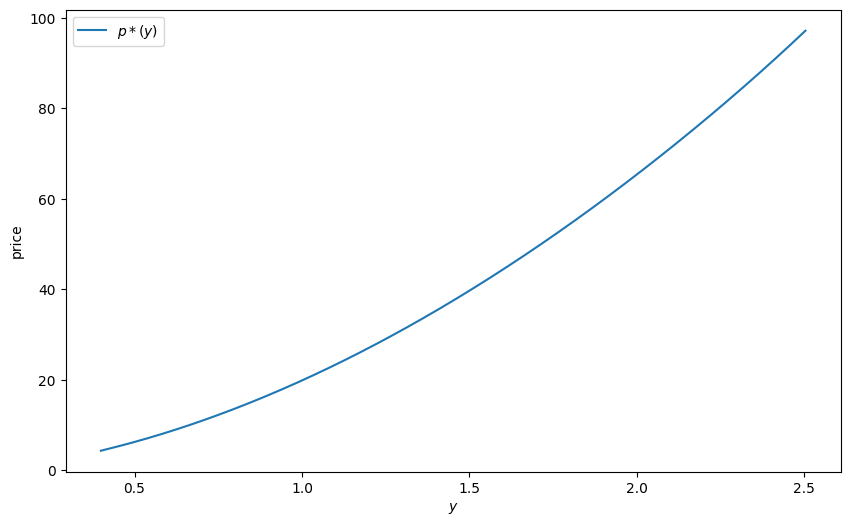

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(grid, price_vals, label='$p*(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('price')
ax.legend()
plt.show()

We see that the price is increasing, even if we remove all serial correlation
from the endowment process.

The reason is that a larger current endowment reduces current marginal utility.

如果 $f(y)$ 没有随 $y$ 增加太快，那么由于 $y^\gamma$ 是递增函数，$p(y)$ 会随着 $y$ 增加而上升。（因为p = f/u', 而边际效用递减）

The price must therefore rise to induce the household to consume the entire endowment (and hence satisfy the resource constraint).

在 Lucas 模型中，消费品是非可储存的；

所以所有 $y_t$ 当期都必须被消费完，即资源约束：$c_t = y_t$ 必须成立；

但是人有贴现因子 $\beta < 1$，更喜欢把资源“储存在未来”；

如果当前 $y_t$ 特别多，边际效用很低（$u'(y_t)$ 很小），人会想“我想少吃点，存着”；

可是模型里不能存！那怎么办？

唯一能调整的是价格 $p(y)$，它必须“变得更贵”，让你不愿买资产，被动地“消费完当期所有 $y_t$”；

所以价格 $p(y)$ 必须随着 $y$ 上升而上升，才能让你别试图把资源存到未来，从而满足 $c_t = y_t$ 的资源约束。

### JAX Code

Here’s a JAX version of the same problem.

In [8]:
def create_lucas_tree_model(γ=2,            # CRRA utility parameter
                            β=0.95,         # Discount factor
                            α=0.90,         # Correlation coefficient
                            σ=0.1,          # Volatility coefficient
                            grid_size=500,
                            draw_size=1_000,
                            seed=11):
        # Set the grid interval to contain most of the mass of the
        # stationary distribution of the consumption endowment
        ssd = σ / jnp.sqrt(1 - α**2)
        grid_min, grid_max = jnp.exp(-4 * ssd), jnp.exp(4 * ssd)
        grid = jnp.linspace(grid_min, grid_max, grid_size)

        # Set up distribution for shocks
        key = jax.random.key(seed)
        draws = jax.random.lognormal(key, σ, shape=(draw_size,))
        grid_reshaped = grid.reshape((grid_size, 1))
        draws_reshaped = draws.reshape((-1, draw_size))
        h = β * jnp.mean((grid_reshaped**α * draws_reshaped) ** (1-γ), axis=1)
        params = γ, β, α, σ
        arrays = grid, draws, h
        return params, arrays

#### 对比
---

## 🔍 函数功能总体回顾

这段函数是用来生成 Lucas Tree 模型的输入，包括：

- 模型参数 $(\gamma, \beta, \alpha, \sigma)$；
- 状态网格 `grid`；
- 蒙特卡洛抽样 `draws`；
- 用于 Lucas operator 的非递归项 $h(y)$，其形式为：

  $$
  h(y) = \beta \cdot \mathbb{E}[(y^\alpha \cdot z)^{1 - \gamma}]
  $$

---

## 🧩 分段详解（JAX 版）

### 📌 网格构建部分

```python
ssd = σ / jnp.sqrt(1 - α**2)
grid_min, grid_max = jnp.exp(-4 * ssd), jnp.exp(4 * ssd)
grid = jnp.linspace(grid_min, grid_max, grid_size)
```

- 和 NumPy 版本一样，先计算 $\ln y$ 的稳态标准差 $\text{ssd} = \sigma / \sqrt{1 - \alpha^2}$；
- 然后构造 $y$ 网格区间：$[\exp(-4 \cdot \text{ssd}), \exp(4 \cdot \text{ssd})]$；
- 用 `jnp.linspace` 均分成 `grid_size` 个点，作为状态网格。

---

### 🎲 生成蒙特卡洛抽样

```python
key = jax.random.key(seed)
draws = jax.random.lognormal(key, σ, shape=(draw_size,))
```

- JAX 的随机数生成方式和 NumPy 不一样，需要先手动创建“随机种子 key”；
- `jax.random.lognormal(key, σ)` 会生成服从 $\log \mathcal{N}(0, \sigma^2)$ 的样本（对应 $e^{\sigma \epsilon}$）；
- 注意：JAX 中的随机函数是**纯函数**，必须显示传入和返回 `key`（这点和 NumPy 最大不同）。

---

### 🧮 批量计算 $h(y)$ 向量（重点）

```python
grid_reshaped = grid.reshape((grid_size, 1))
draws_reshaped = draws.reshape((-1, draw_size))
h = β * jnp.mean((grid_reshaped**α * draws_reshaped) ** (1-γ), axis=1)
```

这是在同时计算所有 $y$ 网格点对应的 $h(y)$ 值。核心逻辑：

- `grid_reshaped`: 变成 `(grid_size, 1)`，方便广播；
- `draws_reshaped`: 变成 `(1, draw_size)`，实现网格与样本的“外积”结构；
- 广播后生成一个 $(grid\_size, draw\_size)$ 的大矩阵，其中每一行是一个特定 $y$ 值下对应的 Monte Carlo 样本；
- 对每行取 $(y^\alpha z)^{1 - \gamma}$ 的平均，乘以 $\beta$，就得到了 $h(y)$ 向量。

这是 JAX 风格：**用向量化和广播**替代显式 for 循环，避免 Python 层级的慢操作，适合 JIT 编译和加速。

---

## 📦 返回结果

```python
params = γ, β, α, σ
arrays = grid, draws, h
return params, arrays
```

结构和 NumPy 版本完全一样，只是内部用的是 JAX 数组。


We’ll use the following function to simultaneously compute the expectation

$$
\int f[G(y, z)] \phi(dz)
$$

over all $ y $ in the grid, under the current specifications.

In [9]:
@jax.jit
def compute_expectation(y, α, draws, grid, f):
    return jnp.mean(jnp.interp(y**α * draws, grid, f))

# Vectorize over y
compute_expectation = jax.vmap(compute_expectation,
                               in_axes=(0, None, None, None, None))

#### 解释

## 🔁 背景回顾

在 Lucas Tree 模型中，我们的 Lucas operator $T$ 定义如下：

$$
(Tf)(y) = h(y) + \beta \cdot \mathbb{E}\left[f(G(y, z))\right]
$$

其中 $G(y, z) = y^\alpha \cdot z$，$z = e^{\sigma \epsilon}$ 是对数正态随机变量。

我们要对每个 $y$，计算：

$$
\mathbb{E}\left[f(y^\alpha \cdot z)\right] \approx \frac{1}{N} \sum_{i=1}^N f(y^\alpha \cdot z_i)
$$

---

## 🔧 函数定义：单个 $y$ 的期望计算

```python
@jax.jit
def compute_expectation(y, α, draws, grid, f):
    return jnp.mean(jnp.interp(y**α * draws, grid, f))
```

### 解释：

- `y`: 单个 $y$ 值（标量）；
- `α`: 模型参数；
- `draws`: Monte Carlo 样本 $z_i = e^{\sigma \epsilon_i}$；
- `grid`: 状态网格上定义的 $f$；
- `f`: 当前 $f$ 值（在 `grid` 上的函数值）；
- `y**α * draws`: 就是 $y^\alpha \cdot z_i$；
- `jnp.interp(...)`: 对不在 grid 上的 $y^\alpha z_i$ 用线性插值求 $f(y^\alpha z_i)$；
- `jnp.mean(...)`: 对这些值求平均，近似 $\mathbb{E}[f(G(y, z))]$。

### 所以这个函数的作用是：

> 给定一个 $y$，返回 $\mathbb{E}[f(G(y, z))]$ 的近似值。

---

## 🔁 向量化：一次处理所有 $y$

```python
compute_expectation = jax.vmap(compute_expectation,
                               in_axes=(0, None, None, None, None))
```

### 含义：

- `vmap` 相当于一个 **自动写 for 循环但不牺牲 JAX 加速特性** 的高阶函数；
- `in_axes=(0, None, None, None, None)` 表示：
  - 第一个参数 `y` 是一个数组，我们要对它的每一项分别应用 `compute_expectation`；
  - 后面的参数（`α`, `draws`, `grid`, `f`）保持不变，对所有 $y$ 公用。

### 等价操作（伪代码）：

```python
results = []
for y_i in y_vec:
    results.append(compute_expectation(y_i, α, draws, grid, f))
```

但这样写是 Python 级别的循环，**效率低**；而 `vmap` 是 **JAX 级别的批量并行计算**，**效率高**。

---

## ✅ 总结：这段代码做了什么？

| 步骤 | 作用 |
|------|------|
| `compute_expectation(...)` | 计算单个 $y$ 的 $\mathbb{E}[f(G(y, z))]$ |
| `vmap(..., in_axes=(0,...))` | 对整个 $y$ 向量做并行计算，返回整个 $\mathbb{E}[f(G(y, z))]$ 向量 |
| `@jax.jit` | 加速整个函数，支持 GPU/TPU/CPU 编译执行 |




Here’s the Lucas operator

In [10]:
@jax.jit
def T(params, arrays, f):
    """
    The Lucas operator

    """
    grid, draws, h = arrays
    γ, β, α, σ = params
    mci = compute_expectation(grid, α, draws, grid, f)
    return h + β * mci

We’ll use successive approximation to compute the fixed point.

In [11]:
def successive_approx_jax(T,                     # Operator (callable)
                          x_0,                   # Initial condition
                          tol=1e-6      ,        # Error tolerance
                          max_iter=10_000):      # Max iteration bound
    def body_fun(k_x_err):
        k, x, error = k_x_err
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, error

    def cond_fun(k_x_err):
        k, x, error = k_x_err
        return jnp.logical_and(error > tol, k < max_iter)

    k, x, error = jax.lax.while_loop(cond_fun, body_fun,
                                    (1, x_0, tol + 1))
    return x

successive_approx_jax = \
    jax.jit(successive_approx_jax, static_argnums=(0,)) #T 是一个 “静态参数”（也就是不能变化的函数对象）；

k, x, error = jax.lax.while_loop(cond_fun, body_fun, (1, x_0, tol + 1))

jax.lax.while_loop 是 JAX 的低级循环结构，用于在 JIT 编译下执行循环（原生 Python 的 while 循环不能被 JIT 编译）；

初始状态是 (k=1, x_0, error=tol+1)；

在 cond_fun 满足条件时，不断调用 body_fun 更新状态；

最终返回的是收敛后的 (k, x, error)，但这里只取 x 作为固定点近似解返回。



Here’s a function that solves the model

In [12]:
def solve_model(params, arrays, tol=1e-6, max_iter=500):
    """
    Compute the equilibrium price function.

    """
    # Simplify notation
    grid, draws, h = arrays
    γ, β, α, σ = params
    _T = lambda f: T(params, arrays, f)
    f = jnp.ones_like(grid)  # Initial guess of f

    f = successive_approx_jax(_T, f, tol=tol, max_iter=max_iter)

    price = f * grid**γ  # Back out price vector

    return price

Now let’s solve the model again and compare timing

In [13]:
params, arrays = create_lucas_tree_model()
grid, draws, h = arrays
γ, β, α, σ = params

# Solve once to compile
start = time()
price_vals = solve_model(params, arrays).block_until_ready()
jax_with_compile_time = time() - start
print("JAX compile plus execution time = ", jax_with_compile_time)

JAX compile plus execution time =  3.73040509223938


In [14]:
# Now time execution without compile time
start = time()
price_vals = solve_model(params, arrays).block_until_ready()
jax_without_compile_time = time() - start
print("JAX execution time = ", jax_without_compile_time)
print("Speedup factor = ", numba_without_compile_time/jax_without_compile_time)

JAX execution time =  0.9183523654937744
Speedup factor =  5.722903467918914


Let’s check the solutions are similar

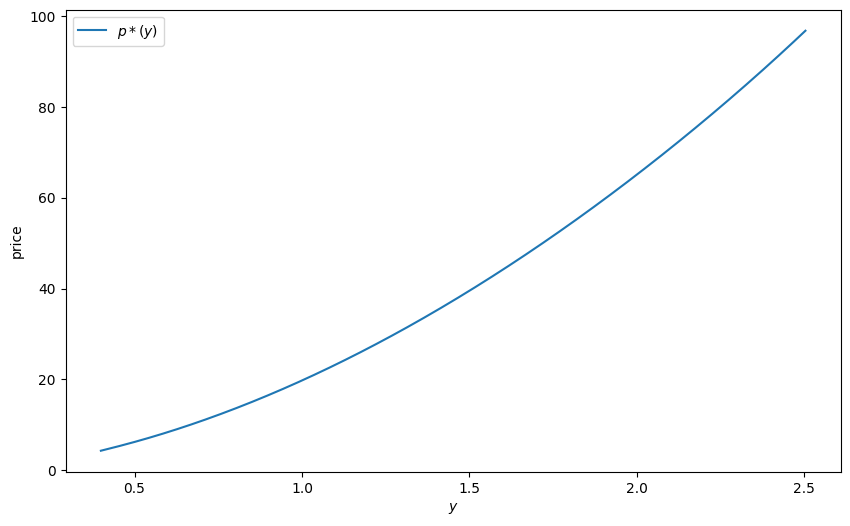

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(grid, price_vals, label='$p*(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('price')
ax.legend()
plt.show()

## Exercises


<a id='lucas-asset-ex1'></a>

## Exercise 8.1

When consumers are more patient the asset becomes more valuable, and the price of the Lucas tree shifts up.

Show this by plotting the price function for the Lucas tree when $ \beta = 0.95 $ and $ 0.98 $.

## Solution to[ Exercise 8.1](https://jax.quantecon.org/#lucas_ex1)

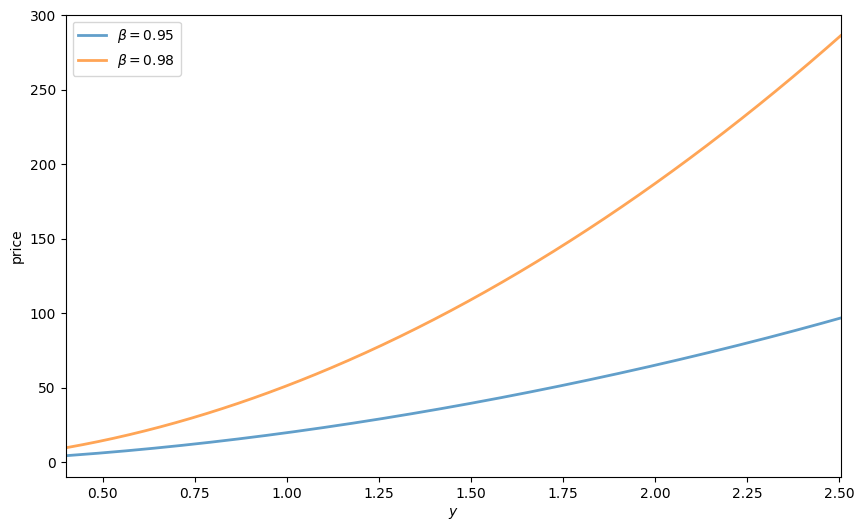

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

for β in (.95, 0.98):
    params, arrays = create_lucas_tree_model(β=β)
    grid, draws, h = arrays
    γ, beta, α, σ = params
    price_vals = solve_model(params, arrays)
    label = rf'$\beta = {beta}$'
    ax.plot(grid, price_vals, lw=2, alpha=0.7, label=label)

ax.legend(loc='upper left')
ax.set(xlabel='$y$', ylabel='price', xlim=(min(grid), max(grid)))
plt.show()